In [5]:
# 1 — Imports
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time, os, csv
from pathlib import Path


In [6]:
# 2 — Paths
DATA_DIR = Path("../data")
MODEL_DIR = Path("../models")
EXP_DIR = Path("../experiments")

device = "cpu"


In [19]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_set = datasets.MNIST(root=DATA_DIR, train=False, download=False, transform=transform)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)


In [20]:
class FFN(nn.Module):
    def __init__(self):
        super().__init__()
        # MUST match baseline: Sequential with "net"
        self.net = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

float_model = FFN()
float_model.load_state_dict(torch.load(MODEL_DIR / "ffn_baseline.pth"))
float_model.eval()


FFN(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [21]:
class QuantFFN(nn.Module):
    def __init__(self):
        super().__init__()
        self.quant = torch.ao.quantization.QuantStub()
        # MUST match baseline sequential keys
        self.net = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        self.dequant = torch.ao.quantization.DeQuantStub()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.quant(x)
        x = self.net(x)
        x = self.dequant(x)
        return x

quant_model = QuantFFN()
quant_model.load_state_dict(float_model.state_dict())
quant_model.eval()


QuantFFN(
  (quant): QuantStub()
  (net): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
  (dequant): DeQuantStub()
)

In [22]:
quant_model.qconfig = torch.ao.quantization.get_default_qconfig("fbgemm")
torch.ao.quantization.prepare(quant_model, inplace=True)

# Calibration using test set (representative data)
with torch.no_grad():
    for x, _ in test_loader:
        quant_model(x)


/tmp/ipykernel_67476/1163726424.py:2: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  torch.ao.quantization.prepare(quant_model, inplace=True)


In [23]:
torch.ao.quantization.convert(quant_model, inplace=True)
print("Quantization complete.")


/tmp/ipykernel_67476/2053038466.py:1: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  torch.ao.quantization.convert(quant_model, inplace=True)


Quantization complete.


In [24]:
torch.ao.quantization.convert(quant_model, inplace=True)
print("Quantization complete.")


Quantization complete.


/tmp/ipykernel_67476/2053038466.py:1: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  torch.ao.quantization.convert(quant_model, inplace=True)


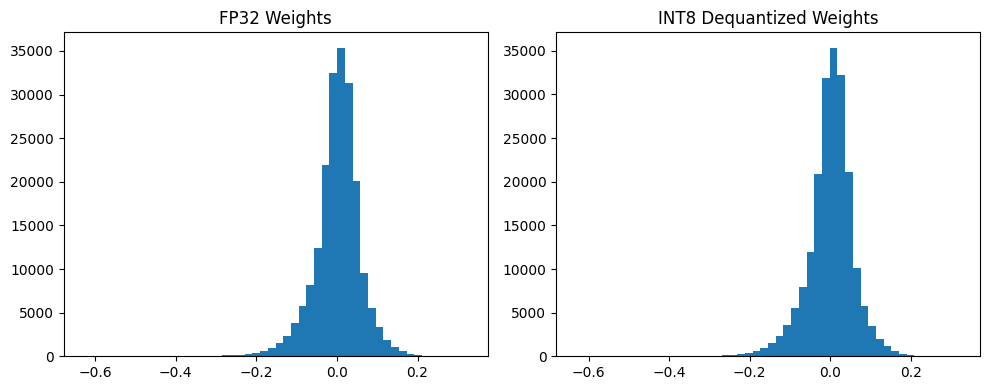

In [25]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(float_model.net[0].weight.detach().numpy().flatten(), bins=50)
plt.title("FP32 Weights")

plt.subplot(1,2,2)
plt.hist(torch.dequantize(quant_model.net[0].weight()).numpy().flatten(), bins=50)
plt.title("INT8 Dequantized Weights")

plt.tight_layout()
plt.show()


In [26]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    start = time.time()
    
    with torch.no_grad():
        for x, y in loader:
            pred = model(x).argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    
    latency = (time.time() - start) / total
    accuracy = correct / total
    return accuracy, latency


In [27]:
acc, latency = evaluate(quant_model, test_loader)
print(f"PTQ Accuracy: {acc:.4f}")
print(f"PTQ Latency (sec/sample): {latency:.6f}")


PTQ Accuracy: 0.9780
PTQ Latency (sec/sample): 0.001017


In [28]:
tmp_file = MODEL_DIR / "tmp_quant.pth"
torch.save(quant_model.state_dict(), tmp_file)
size_kb = os.path.getsize(tmp_file) / 1024
tmp_file.unlink()
print(f"PTQ Model Size (KB): {size_kb:.2f}")


PTQ Model Size (KB): 243.78


In [29]:
torch.save(quant_model.state_dict(), MODEL_DIR / "quantized_model.pth")
print("Quantized model saved to models/quantized_model.pth")


Quantized model saved to models/quantized_model.pth


In [30]:
csv_file = EXP_DIR / "results.csv"
write_header = not csv_file.exists()

with open(csv_file, "a", newline="") as f:
    writer = csv.writer(f)
    if write_header:
        writer.writerow(["Model", "Accuracy", "Size", "Latency"])
    writer.writerow(["FFN PTQ", acc, size_kb, latency])
print("Results appended to experiments/results.csv")


Results appended to experiments/results.csv
